# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание предоставленных данных:**

* Признаки: 

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

* Целевой признак:

Price — цена (евро)

Установка необходимых инструментов:

In [1]:
!pip install --upgrade scikit-learn -q

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


## Подготовка данных

Необходимые для анализа функции:

In [2]:
def bas_research (data):
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')
    pass_ = pd.DataFrame(data.isna().sum()).style.set_table_attributes('style="width: 60%; margin: auto;"').set_caption('Количество пропусков:')
    return(pass_)

def implicit_duplicates (data, cat_features):
    for i in cat_features:
        print(f'Название категории: {i}')
        print(f'Число уникальный значений: {len(data[i].unique())}')
        display(pd.DataFrame(data[i].unique()).style.set_table_attributes('style="width: 60%; margin: auto;"').hide_index())
        print()
        
def box(data, columns):
    numerical_cols = columns
    display(data[columns].describe())
    for i in numerical_cols:
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=data[i])
        plt.title(i)
        plt.xticks(rotation=45) 
        plt.grid()
        plt.show()
        Q1 = data[i].quantile(0.25)
        Q3 = data[i].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        anomalies = data[(data[i] < lower_bound) | (data[i] > upper_bound)]
        print(f'Количество выбивающихся значений в {i}: {len(anomalies)}')

### Первичный анализ данных 

In [3]:
data = pd.read_csv('/datasets/autos.csv')
print(data.info())
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Приведём названия столбцов к нужному стилю. 

In [4]:
data.columns = data.columns.str.lower()
data = data.rename(columns = {'datecrawled':"date_crawled", 
"vehicletype":"vehicle_type", "registrationyear":"registration_year", "registrationmonth":"registration_month",
"fueltype":"fuel_type", "datecreated":"date_created", "numberofpictures":"number_of_pictures",
"postalcode":"postal_code", "lastseen":"last_seen"})


Проанализируем данные на наличие явных дубликатов и пропусков. 

In [5]:
bas_research(data) 

Количество явных дубликатов: 4


,0
date_crawled,0
price,0
vehicle_type,37490
registration_year,0
gearbox,19833
power,0
model,19705
kilometer,0
registration_month,0
fuel_type,32895


Пропуски есть лишь в категориальных столбцах. К тому же в тех, которые заполняются самими владельцами автомобилей. Устраним эту проблему чуть позже. 


Устраним явные дубликаты. 

In [6]:
data = data.drop_duplicates()

Проанализируем данные на наличие неявных дубликатов. 

In [7]:
implicit_duplicates(data, ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'])

Название категории: vehicle_type
Число уникальный значений: 9


0
nan
coupe
suv
small
sedan
convertible
bus
wagon
other



Название категории: gearbox
Число уникальный значений: 3


0
manual
auto
nan



Название категории: model
Число уникальный значений: 251


0
golf
nan
grand
fabia
3er
2_reihe
other
c_max
3_reihe
passat



Название категории: fuel_type
Число уникальный значений: 8


0
petrol
gasoline
nan
lpg
other
hybrid
cng
electric



Название категории: brand
Число уникальный значений: 40


0
volkswagen
audi
jeep
skoda
bmw
peugeot
ford
mazda
nissan
renault



Название категории: repaired
Число уникальный значений: 3


0
nan
yes
no


Неявных дубликатов не было замечено. 

### Изучение данных на выбросы, аномалии и особенности

,price,power,kilometer,number_of_pictures,registration_year
count,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,110.093816,128211.363989,0.0,2004.234481
std,4514.176349,189.851330,37905.083858,0.0,90.228466
min,0.000000,0.000000,5000.000000,0.0,1000.000000
25%,1050.000000,69.000000,125000.000000,0.0,1999.000000
50%,2700.000000,105.000000,150000.000000,0.0,2003.000000
75%,6400.000000,143.000000,150000.000000,0.0,2008.000000
max,20000.000000,20000.000000,150000.000000,0.0,9999.000000


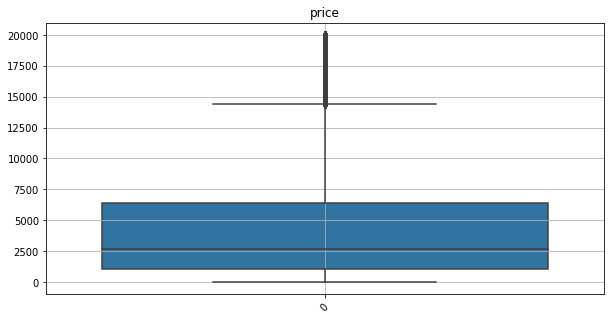

Количество выбивающихся значений в price: 18979


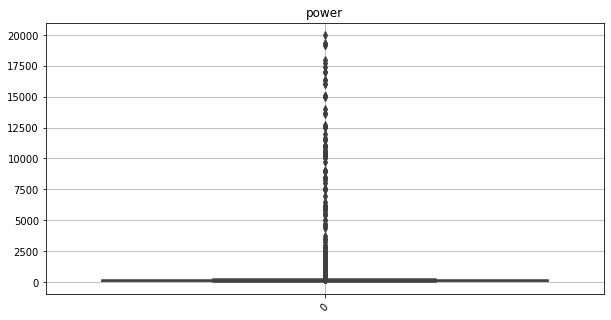

Количество выбивающихся значений в power: 7340


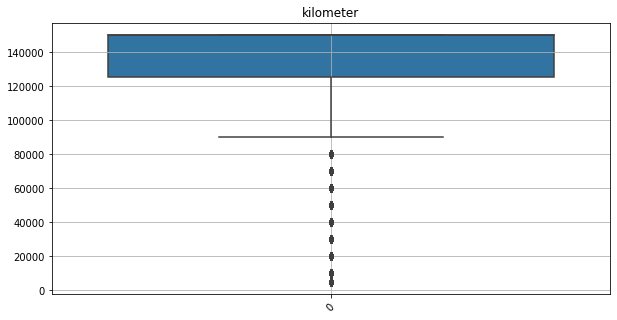

Количество выбивающихся значений в kilometer: 53256


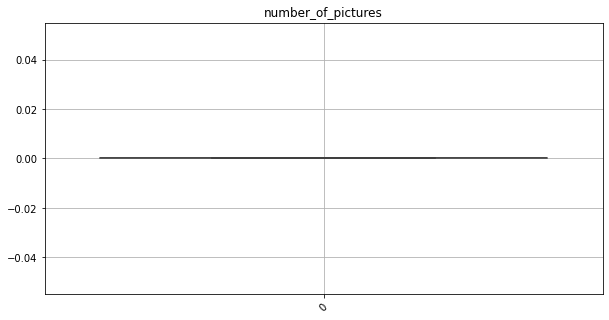

Количество выбивающихся значений в number_of_pictures: 0


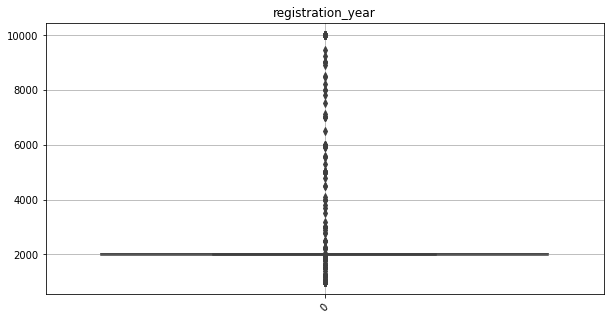

Количество выбивающихся значений в registration_year: 6309


In [8]:
box(data, ['price', 'power', 'kilometer', 'number_of_pictures', 'registration_year'])

Проанализируем аномалии в столбце года регистрации автомобиля. 

In [9]:
Q1 = data['registration_year'].quantile(0.25)
Q3 = data['registration_year'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
anomalies = data[(data['registration_year'] < lower_bound) | (data['registration_year'] > upper_bound)]
print(f'Нижняя граница размаза: {lower_bound}')
print(f'Верхняя граница размаха: {upper_bound}')
print(f'Всего наблюдений ниже нижней границы: {len(data[data["registration_year"] < lower_bound])}')
print(f'Всего наблюдений выше верхней границы: {len(data[data["registration_year"] > upper_bound])}')

Нижняя граница размаза: 1985.5
Верхняя граница размаха: 2021.5
Всего наблюдений ниже нижней границы: 6204
Всего наблюдений выше верхней границы: 105


In [10]:
data['year_crawled'] = pd.to_datetime(data['date_crawled']).dt.year
print(f'Последний год выгрузки из базы данных: {data.sort_values(by="year_crawled", ascending=False)["year_crawled"].iloc[0]}')

Последний год выгрузки из базы данных: 2016


Даты регистрации раньше 1985 вполне допустимы. Поставим нижнюю границу в районе 30-х годов. Продажа автомобилей более раннего времени представляется мало возможным. Также будем считать аномалией даты регистрации позднее 2016 года. 

Таких ошибочных данных не так уж и много и их можно было бы удалить, но мы попытаемся их востановить.

Посмотрим на распределение разницы между годом регистрации и годом созданий анкеты. 

In [11]:
analysis = data
analysis['year_created'] = pd.to_datetime(analysis['date_created']).dt.year
analysis = analysis[(analysis['registration_year'] > 1930) & (analysis['registration_year'] < 2016)]
difference = (analysis['year_created']-analysis['registration_year'])
print(pd.DataFrame(difference).describe())


                   0
count  330050.000000
mean       13.878143
std         6.585609
min         0.000000
25%         9.000000
50%        14.000000
75%        17.000000
max        85.000000


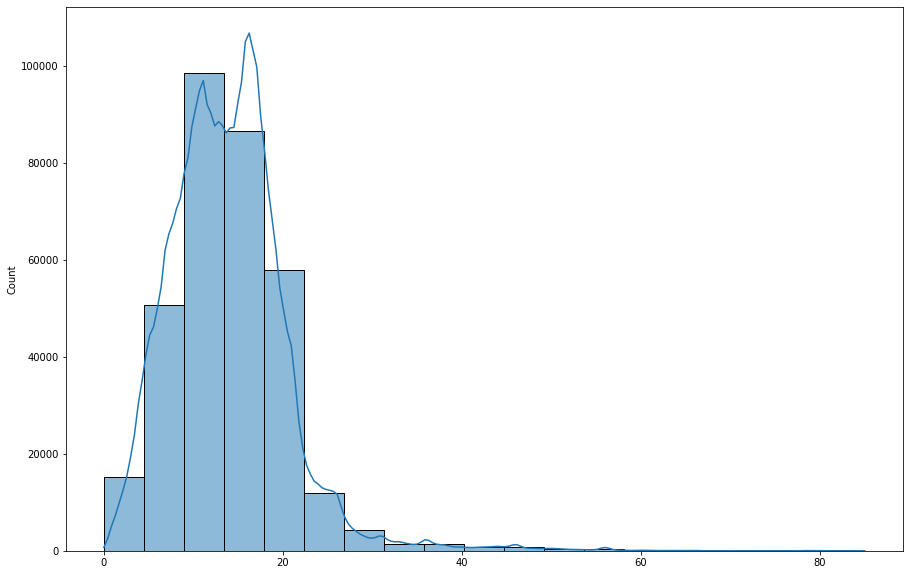

In [12]:
def hist(data):
    plt.figure(figsize=(15,10))
    sns.histplot(data, bins=19, kde=True)

hist(difference)

Наблюдается явная устойчивость этой разницы. В целом распределение имеет форму нормального распределения, со смещением влево. Среднее и медиана почти совпадают.

Заменим аномальные значения таким образом: от года создания анкеты отнимим медиану найденного нами распределения. Это и будет нашей оценкой истинного значения даты регистрации автомобиля. 

In [13]:
data['year_created'] = pd.to_datetime(data['date_created']).dt.year
data['registration_year'] = data.apply(
lambda row: row['year_created'] - 13 if (row['registration_year'] < 1930) or (row['registration_year'] > 2016)
else row['registration_year'],
axis = 1
)
anomalies = data[(data['registration_year'] < 1930) | (data['registration_year'] > 2016)]
print(f'Количество аномалий: {len(anomalies)}')


Количество аномалий: 0


Исправили проблему с годом регистрации. 

Также замечена странная особенность данных - количестве фотографий во всех строках нулевое. Этот столбец становится бесполезным, так как обладает нулевой вариацией. 

В том, что машина может стоить десятки тысяч евро нет ничего странного, как и то, что есть машины, которые практически или вообще не использовались, из-за чего и накатали малое расстояние. 

### Анализ признаков

* Признаки: 

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

Не информативные признаки:
1. DateCrawled 
* Дата скачивания анкеты никак не может влиять на стоимость.
2. RegistrationMonth 
* Месяц регистрации также едва ли как-то связан с ценой автомобиля.
* Тем не менее год регистрации будет оставлен по причине влияния инфляции на общий уровень цен, в частности и на цену автомобилей. 
3. PostalCode
* Почтовый индекс никак не связан с ценой.
4. LastSeen 
* Дата последней активности также никаким образом не влияет на цену. 
5. NumberOfPictures
* Количество фотографий могло бы в теории быть связано с ценой, но предоставленные данные имеют нулевую вариацию по этому признаку. В нем нет никакой информации. 
6. DateCreated 
* Дата создания также никаким очевидным образом не связано с ценой. 


Удалим все неинформативные столбцы. Таким образом мы упростим работу моделей. 

In [14]:
data_clean = data.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen', 'year_created', 'year_crawled'], axis = 1)
print(f'Информативных столбцов: {len(data_clean.columns)}')
data_clean.head(10)

Информативных столбцов: 10


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN


### Обработка пропусков


**repaired**

In [15]:
data_clean['repaired'] = data_clean['repaired'].fillna('unknown')

**vehicle_type**

In [16]:
data_clean['vehicle_type'] = data_clean['vehicle_type'].fillna('other')

**fuel_type**

In [17]:
data_clean['fuel_type'] = data_clean['fuel_type'].fillna('other')

**gearbox**

In [18]:
data_clean['gearbox'] = data_clean['gearbox'].fillna('unknown')

**model**

In [19]:
data_clean['model'] = data_clean['model'].fillna('other')

Проверка:

In [20]:
data_clean.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

### Общий вывод

* Данные имеют несколько проблем и особенностей:

1. Имеются аномальные значения в дате регистрации автомобилей. 
2. Число фотографий автомобиля, потенциально полезный для анализа признак, оказался не информативным по причине нулевой вариации. Скорее всего ошибка была допущена при сборе или выгрузке данных.
3. В данных имеется большое число пропусков категорильных данных. 

* Что было сделано:

1. Пропуски были заполнены.
2. Были исключены не информативные признаки. 
3. Аномальные значения в датах регистрации автомобиля были обработаны. 


## Обучение моделей и их оценка

Необходимо закодировать категориальные данные для применения моделей. 

С точки зрения точности лучше всего подходит OneHotEncoder, так как благодаря такой кодировке модель не будет пытаться найти порядок в значениях закодированной категориальной переменной. Однако из-за такого типа кодировки увеличивается размерность данных, что сильно уменьшит скорость обучения моделей. 

Таким образом воспользуемся гибридным решением: категориальные признаки с большим количеством возможных значений будут закодированы LabelEncoder, а остальные OneHotEncoder. 

In [21]:
RANDOM_STATE = 42
target = 'price'

target = data_clean['price']
features = data_clean.drop('price', axis=1)

features_train, features_test_valid, target_train, target_test_valid = train_test_split(
    features, target, test_size=0.40, random_state=RANDOM_STATE
)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test_valid, target_test_valid, test_size=0.50, random_state=RANDOM_STATE
)

features_train.shape, target_train.shape, features_valid.shape, target_valid.shape, features_test.shape, target_test.shape

((212619, 9), (212619,), (70873, 9), (70873,), (70873, 9), (70873,))

In [22]:
ord_columns = ['model', 'brand']
ohe_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']

ord_pipe = Pipeline(
    [('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
    ]
)
ohe_pipe = Pipeline(
    [('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ]
    )
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('ohe', ohe_pipe, ohe_columns)
    ], 
    remainder='passthrough'
)


features_train_trans = data_preprocessor.fit_transform(features_train)
features_valid_trans = data_preprocessor.transform(features_valid)
features_test_trans = data_preprocessor.transform(features_test)

In [23]:
ohe_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'model', 'brand']

data_preprocessor_linear = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns)
    ], 
    remainder='passthrough'
)

features_train_trans_linear = data_preprocessor_linear.fit_transform(features_train)
features_valid_trans_linear = data_preprocessor_linear.transform(features_valid)
features_test_trans_linear = data_preprocessor_linear.transform(features_test)

### Линейная модель

In [24]:
model = LinearRegression()

In [25]:
%%capture result
%%timeit
model.fit(features_train_trans_linear, target_train)

In [26]:
linear_fit_time = result.stdout
linear_fit_time_short = linear_fit_time.split(' per loop ')[0]

In [27]:
predictions = model.predict(features_valid_trans_linear)

In [28]:
%%capture result
%%timeit
model.predict(features_valid_trans_linear)

In [29]:
linear_prediction_time = result.stdout
linear_prediction_time_short = linear_prediction_time.split(' per loop ')[0]

In [30]:
linear_rmse = mean_squared_error(target_valid, predictions) ** 0.5

In [31]:
models_compares = {
    'LinearRegression': {
        'fit_time': linear_fit_time_short,
        'prediction_time': linear_prediction_time_short,
        'rmse': linear_rmse,
    },
}
models_statistics = pd.DataFrame(models_compares).T
models_statistics 

,fit_time,prediction_time,rmse
LinearRegression,19.2 s +- 451 ms,167 ms +- 6.62 ms,2901.170686


### Случайный лес

In [32]:
best_rmse = 5000
best_depth = 0
best_estim = 0
for estim in range(15, 20, 2):
    for depth in range(15, 20, 2):
        model = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=estim, max_depth=depth)
        model.fit(features_train_trans, target_train)
        predictions = model.predict(features_valid_trans)
        rmse = mean_squared_error(target_valid, predictions) ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_depth = depth
            best_estim = estim
print(
    f'Количество деревьев: {best_estim}\n'
    f'Глубина: {best_depth}\n'
    f'RMSE: {best_rmse}'
)

Количество деревьев: 19
Глубина: 19
RMSE: 1795.873375860284


In [33]:
model_forest = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=best_estim, max_depth=best_depth)

In [34]:
%%capture result
%%timeit
model_forest.fit(features_train_trans, target_train)

In [35]:
forest_fit_time = result.stdout
forest_fit_time_short = forest_fit_time.split(' per loop ')[0]

In [36]:
predictions = model_forest.predict(features_valid_trans)

In [37]:
%%capture result
%%timeit
model_forest.predict(features_valid_trans)

In [38]:
forest_prediction_time = result.stdout
forest_prediction_time_short = forest_prediction_time.split(' per loop ')[0]

In [39]:
forest_rmse = mean_squared_error(target_valid, predictions) ** 0.5

In [40]:
models_compares['RandomForestRegressor'] = {
        'fit_time': forest_fit_time_short,
        'prediction_time': forest_prediction_time_short,
        'rmse': forest_rmse,
    }
models_statistics = pd.DataFrame(models_compares).T
models_statistics 

,fit_time,prediction_time,rmse
LinearRegression,19.2 s +- 451 ms,167 ms +- 6.62 ms,2901.170686
RandomForestRegressor,15.2 s +- 101 ms,339 ms +- 5.56 ms,1795.873376


### LightGBM

In [41]:
best_rmse = 5000
best_depth = 0
for depth in range(5, 12, 3):
    model = LGBMRegressor(random_state=RANDOM_STATE, learning_rate=0.5, num_leaves=100, max_depth = depth, n_jobs=-1)
    model.fit(features_train_trans, target_train)
    predictions = model.predict(features_valid_trans)
    rmse = mean_squared_error(target_valid, predictions) ** 0.5
    if rmse < best_rmse:
        best_rmse = rmse
        best_depth = depth
print(
    f'Глубина: {best_depth}\n'
    f'RMSE: {best_rmse}'
)



/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-

Глубина: 8
RMSE: 1760.607646036945


In [42]:
model = LGBMRegressor(random_state=RANDOM_STATE, learning_rate=0.5, num_leaves=100, max_depth = best_depth)

In [43]:
%%capture result
%%timeit
model.fit(features_train_trans, target_train)

In [44]:
lgbm_fit_time = result.stdout
lgbm_fit_time_short = lgbm_fit_time.split(' per loop ')[0]

In [45]:
predictions = model.predict(features_valid_trans)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [46]:
%%capture result
%%timeit
model.predict(features_valid_trans)


In [47]:
lgbm_prediction_time = result.stdout
lgbm_prediction_time_short = lgbm_prediction_time.split(' per loop ')[0]

In [48]:
lgbm_rmse = mean_squared_error(target_valid, predictions) ** 0.5

In [49]:
models_compares['LGBMRegressor'] = {
        'fit_time': '4min 2s +- 7min 1s',
        'prediction_time': lgbm_prediction_time_short,
        'rmse': lgbm_rmse,
    }
models_statistics = pd.DataFrame(models_compares).T
models_statistics

,fit_time,prediction_time,rmse
LinearRegression,19.2 s +- 451 ms,167 ms +- 6.62 ms,2901.170686
RandomForestRegressor,15.2 s +- 101 ms,339 ms +- 5.56 ms,1795.873376
LGBMRegressor,4min 2s +- 7min 1s,628 ms +- 39.3 ms,1760.607646


## Вывод о моделях

### Тестирование и анализ лучшей модели

По соотношению времени к качеству на валидационной выборке лучше всего себя показала модель случайного леса. Посмотрим на точность этой модели на тестовой выборке. 

In [50]:
predict = model_forest.predict(features_test_trans)
final_rmse = mean_squared_error(target_test, predict)**0.5
print(f'RMSE на тестовой выборке: {final_rmse}')

RMSE на тестовой выборке: 1789.5594248586078


Оценим распределение остатков. 

count    70873.000000
mean       -11.298219
std       1789.536384
min     -19208.124571
25%       -635.745972
50%        -87.949876
75%        531.020379
max      18485.550672
Name: price, dtype: float64


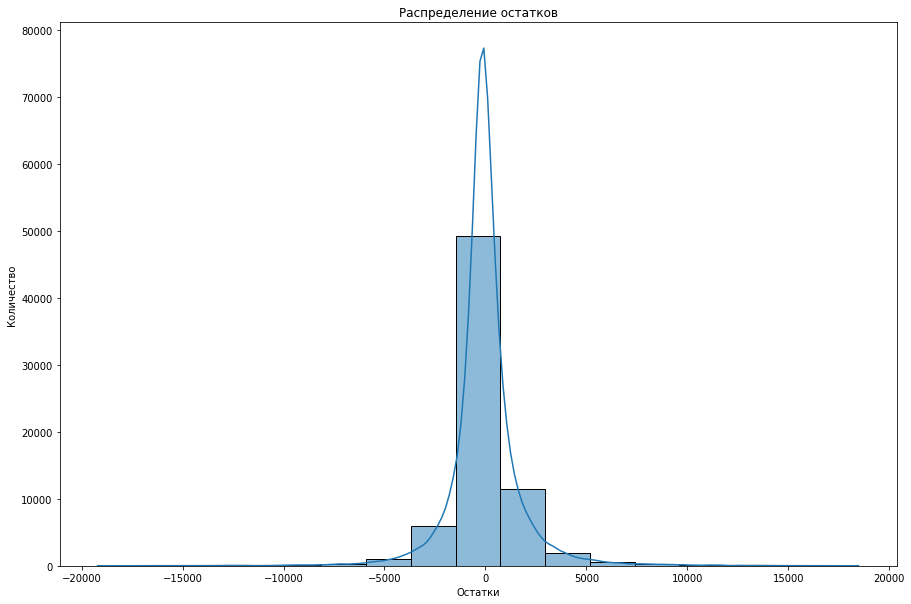

In [51]:
print((target_test-predict).describe())
plt.figure(figsize=(15,10))
sns.histplot(data = target_test-predict, bins = 17, kde=True)
plt.xlabel('Остатки')
plt.ylabel('Количество')
plt.title('Распределение остатков')  
plt.show()

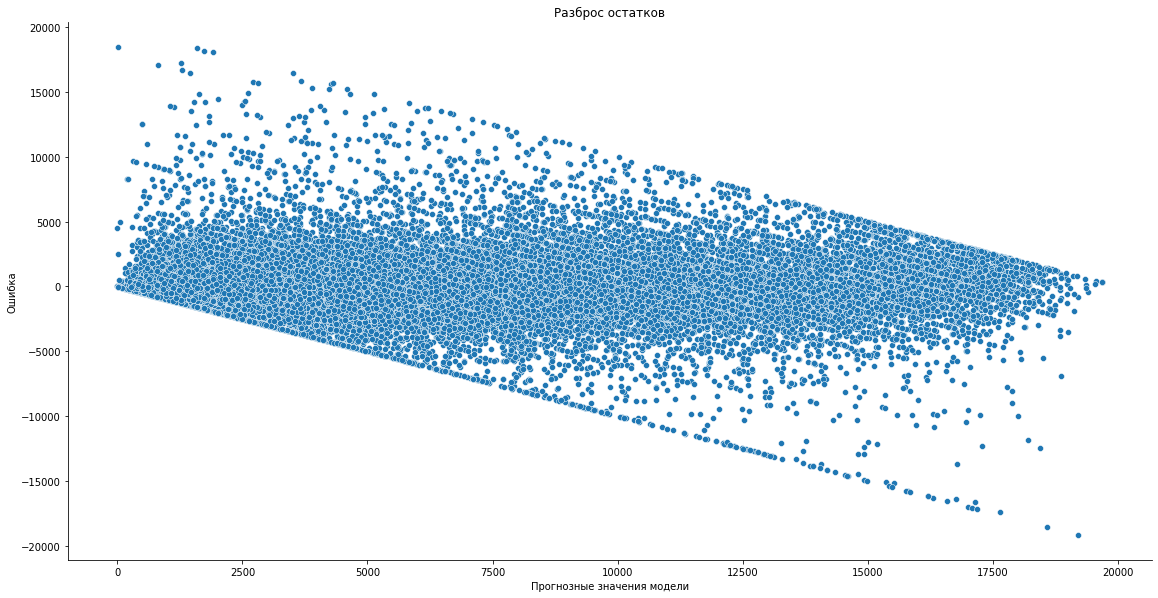

In [52]:
sns.relplot(x=predict, y=target_test - predict, height=8, aspect=2) 
plt.xlabel('Прогнозные значения модели')
plt.ylabel('Ошибка')
plt.title('Разброс остатков')
plt.show()

По статистическим данным видно, что в среднем модель оценивает стоимость автомобилей с небольшим смещением в меньшую сторону, но в целом распределение остатков нормально. Дисперсия модели постояна. 

### Общий вывод

Случайный лес показал хорошие результаты как на валидации, так и на тестовой выборке. Было достигнуто как достаточно высокое значение качества модели (RMSE), так и хорошая скорость обучения и предсказания. 

Для получения высокого качества и скорости модели было сделано:

1. Проведён первичный анализ данных.
2. Обработаны пропуски и аномальные значения. 
3. Проведён анализ признаков; исключены все неинформативные признаки. 
4. Данные подготовлены для использования моделями таким образом, чтобы повысить качество и скорость их обучения. 
5. Лучшая модель на валидации была проверена на тестовых данных; остатки модели проанализированы на смещение и наличие гетероскидастичности.  